In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from sklearn import metrics

## Data Cleaning

In [2]:
closed =pd.read_csv("https://final-project-data-uci-da-bootcamp.s3-us-west-2.amazonaws.com/California_Real_Estate_Raw_Data_Set.csv")

In [3]:
closed_df = pd.DataFrame(closed)

In [4]:
closed_df.drop(columns = ["Unnamed: 0"], inplace = True)

In [5]:
closed_df.drop(columns = ["MLS Area","MLS Area","MLS","BAC","DOM/CDOM","SLC","S","Sub Type"], inplace = True)

In [6]:
closed_df = closed_df.dropna()

In [7]:
closed_df.rename(columns = {"County ": "County"}, inplace = True)

In [8]:
closed_df.rename(columns = {"Contract Status Change Date": "Date"}, inplace = True)

In [9]:
closed_df.Date = pd.to_datetime(closed_df.Date, format = "%m/%d/%y")

In [10]:
closed_df[['Price Per Square Foot']] = closed_df[['Price Per Square Foot']].replace('[\$,]','',regex=True).astype(float)


In [11]:
closed_df[['L/C Price']] = closed_df[['L/C Price']].replace('[\$,]','',regex=True).astype(float)

In [12]:
closed_df[["Sqft"]] = closed_df.Sqft.str.split('/', expand=True).drop([1], axis = 1)

In [13]:
closed_df[["YrBuilt"]] = closed_df.YrBuilt.str.split('/', expand=True).drop([1], axis = 1)

In [14]:
closed_df[["Bed & Bath", "A", "Attic", "Basement"]] = closed_df['Br/Ba'].str.split(",", expand = True)


In [15]:
closed_df[["Bed", "Bath"]] = closed_df["Bed & Bath"].str.split("/", expand = True)

In [16]:
closed_df.drop(columns = ["A"],inplace = True)

In [17]:
closed_df.columns

Index(['Listing ID', 'St#', 'St Name', 'City', 'L/C Price',
       'Price Per Square Foot', 'Br/Ba', 'Sqft', 'YrBuilt', 'LSqft/Ac',
       'View YN', 'Pool Private YN', 'Date', 'County', 'Bed & Bath', 'Attic',
       'Basement', 'Bed', 'Bath'],
      dtype='object')

In [18]:
closed_df.drop(columns = "Bed & Bath", inplace = True)

In [19]:
closed_df.rename(columns = {"Sqft": "Sqft/A"}, inplace = True)
closed_df[["LSqft", "Ac"]] = closed_df['LSqft/Ac'].str.split('/', expand = True).replace('[\$,]','',regex=True).astype(float)

In [20]:
closed_df.drop(columns = ["St#","St Name","City","LSqft/Ac","Ac","Date"], inplace = True)

In [21]:
len(closed_df.columns)

14

In [22]:
closed_df.rename(columns = {"Price Per Square Foot":"Price_Per_Squqre_Foot", "Pool Private YN":"Private_Pool","View YN":"View"}, inplace = True)

In [23]:
clean_df = closed_df

In [24]:
clean_df.replace({"Y":1,"N":0},inplace = True)

In [25]:
clean_df.drop(columns = ["Br/Ba"], inplace = True)

In [26]:
clean_df["Sqft/A"] =clean_df["Sqft/A"].astype(int)

In [27]:
clean_df.YrBuilt = clean_df.YrBuilt.astype(int)

In [28]:
clean_df.Attic = clean_df.Attic.astype(int)

In [29]:
clean_df.Basement = clean_df.Basement.astype(int)

In [30]:
clean_df.Bed = clean_df.Bed.astype(int)
clean_df.Bath = clean_df.Bath.astype(int)

In [31]:
clean_df.drop(columns = ["Listing ID"], inplace = True)

In [32]:
clean_df.columns

Index(['L/C Price', 'Price_Per_Squqre_Foot', 'Sqft/A', 'YrBuilt', 'View',
       'Private_Pool', 'County', 'Attic', 'Basement', 'Bed', 'Bath', 'LSqft'],
      dtype='object')

In [33]:
[clean_df.County == "Riverside"] or [clean_df.County ==  "Los Angeles"] or [clean-df.County == "Orange"]

[0        False
 1        False
 2        False
 3        False
 4        False
          ...  
 22104    False
 22105    False
 22106    False
 22107    False
 22108    False
 Name: County, Length: 22045, dtype: bool]

In [34]:
riverside = clean_df[clean_df.County == "Riverside"]
los_angeles = clean_df[clean_df.County == "Los Angeles"]
orange = clean_df[clean_df.County == "Orange"]


In [35]:
CA = riverside.append(los_angeles)

In [36]:
ca_df = CA.append(orange)

In [37]:
ca_df.reset_index()

,index,L/C Price,Price_Per_Squqre_Foot,Sqft/A,YrBuilt,View,Private_Pool,County,Attic,Basement,Bed,Bath,LSqft
0,9639,234900.0,257.57,912,1922,1,0,Riverside,1,0,1,1,6970.0
1,9640,309900.0,295.14,1050,1977,1,0,Riverside,0,0,2,1,8712.0
2,9641,329500.0,208.02,1584,1974,1,0,Riverside,0,0,3,2,7405.0
3,9642,549900.0,286.11,1922,1980,1,0,Riverside,0,0,4,2,432115.0
4,9643,645000.0,173.15,3725,2006,1,0,Riverside,0,0,4,3,57064.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12595,2631,1080000.0,322.58,3348,1969,0,1,Orange,1,0,5,3,10337.0
12596,2632,1175000.0,512.43,2293,1969,1,0,Orange,0,0,4,2,15300.0
12597,2633,1215000.0,402.72,3017,1984,0,1,Orange,1,0,4,3,11000.0
12598,2634,1282000.0,434.72,2949,2017,1,1,Orange,0,0,4,3,5592.0


In [38]:
county_rank = ca_df.loc[:,["L/C Price", "County"]]

In [39]:
county_rank = county_rank.groupby("County").mean()

In [40]:
county_rank.sort_values(by = "L/C Price")

,L/C Price
County,
Riverside,440979.083133
Los Angeles,668418.699097
Orange,838997.170416


In [41]:
ca_df.replace({"Riverside":1, "Los Angeles":2, "Orange":3}, inplace = True)

In [42]:
ca_df.head()

,L/C Price,Price_Per_Squqre_Foot,Sqft/A,YrBuilt,View,Private_Pool,County,Attic,Basement,Bed,Bath,LSqft
9639,234900.0,257.57,912,1922,1,0,1,1,0,1,1,6970.0
9640,309900.0,295.14,1050,1977,1,0,1,0,0,2,1,8712.0
9641,329500.0,208.02,1584,1974,1,0,1,0,0,3,2,7405.0
9642,549900.0,286.11,1922,1980,1,0,1,0,0,4,2,432115.0
9643,645000.0,173.15,3725,2006,1,0,1,0,0,4,3,57064.0


## Starting the model

In [43]:
ca_model = ca_df.reset_index()

In [44]:
ca_model.drop(columns = 'index', inplace = True)

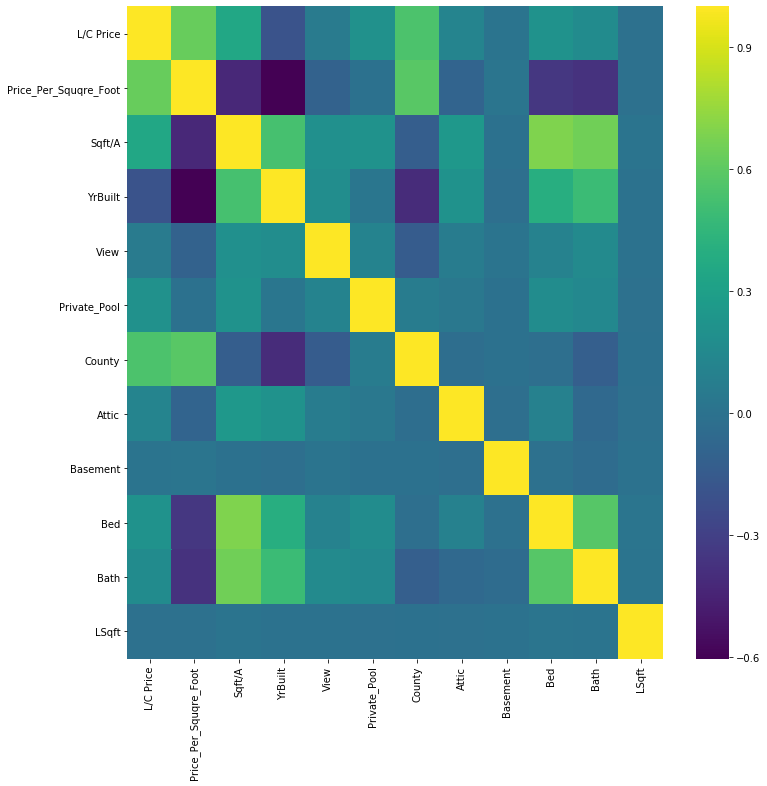

In [45]:
ca_model
fig = plt.figure(figsize = (12,12))
sns.heatmap(ca_model.corr(), annot = False, vmax = 1, cmap = 'viridis', square = False)

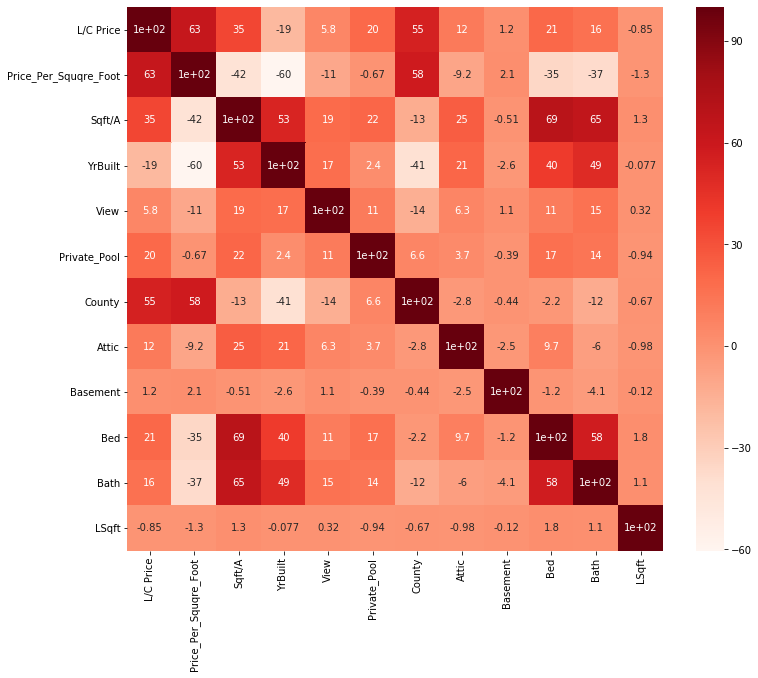

In [46]:
plt.figure(figsize = (12,10))
cor = ca_model.corr()*100
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

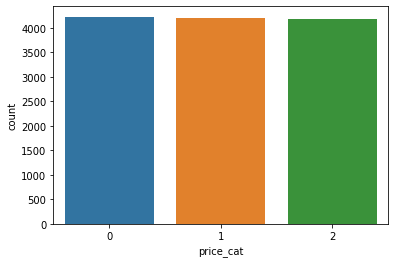

In [47]:
ca_classification = ca_model.assign(
    price_cat = pd.qcut(
        ca_model['L/C Price'],
        q=3,
        duplicates='drop',
        labels=[0,1,2]
    )
)

# Visualize the Split
sns.countplot(ca_classification['price_cat'])

In [48]:
ca_classification.columns

Index(['L/C Price', 'Price_Per_Squqre_Foot', 'Sqft/A', 'YrBuilt', 'View',
       'Private_Pool', 'County', 'Attic', 'Basement', 'Bed', 'Bath', 'LSqft',
       'price_cat'],
      dtype='object')

In [49]:
y = ca_classification['L/C Price']
X =ca_classification[['Price_Per_Squqre_Foot', 'Sqft/A', 'YrBuilt', 'View',
       'Private_Pool', 'County', 'Attic', 'Basement', 'Bed', 'Bath', 'LSqft']]

In [50]:
X.head(1)

,Price_Per_Squqre_Foot,Sqft/A,YrBuilt,View,Private_Pool,County,Attic,Basement,Bed,Bath,LSqft
0,257.57,912,1922,1,0,1,1,0,1,1,6970.0


In [51]:
y.head(1)

0    234900.0
Name: L/C Price, dtype: float64

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
X_test.shape

(2520, 11)

In [54]:
X_train.shape

(10080, 11)

In [55]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
print(f"Training Data Score: {regressor.score(X_train, y_train)}")
print(f"Testing Data Score: {regressor.score(X_test, y_test)}")

Training Data Score: 0.8746552214273663
Testing Data Score: 0.8627605160129335


In [56]:
y_pred = regressor.predict(X_test)
y_pred

array([994771.95726824, 729721.31946613, 272826.95117134, ...,
       544392.95174809, 503885.32850255, 869444.4798433 ])

In [57]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df
df1 = df

In [58]:
df1

,Actual,Predicted
11385,1060000.0,9.947720e+05
6866,775000.0,7.297213e+05
1323,340000.0,2.728270e+05
2252,410000.0,3.585231e+05
11277,631000.0,6.886481e+05
...,...,...
5353,1550000.0,1.209774e+06
4295,382500.0,3.519029e+05
7541,495000.0,5.443930e+05
6778,535000.0,5.038853e+05


In [59]:
 from sklearn.metrics import mean_squared_error

In [60]:
pattern = "%.0f"
y_pred = [pattern % int(i) for i in y_pred]
y_pred = [int(i) for i in y_pred]
mean_squared_error(y_test, y_pred)

10732868009.704762

In [61]:
from sklearn.metrics import r2_score
print('R2 Score: ', r2_score(y_test,y_pred))

R2 Score:  0.8627605510785034


In [62]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 69206.26349206349
Mean Squared Error: 10732868009.704762
Root Mean Squared Error: 103599.55603044234


## Saving the model to load into Flask

In [63]:
import pickle

In [64]:
# Saving model to disk
pickle.dump(regressor, open('model_2.pkl','wb'))

In [65]:
# 309900.0	295.14	1050	1977	1	0	1	0	0	2	1	8712.0

In [66]:
# Loading model to compare the results
model_2 = pickle.load(open('model_2.pkl','rb'))
print(model_2.predict([[295.14,1050,1977,1,0,1,0,0,2,1,8712.0]]))

[234266.5144085]
